In [1]:
from utils_project import *

Initial n=579
Validation n=255
Combined n=834
Questionnaire items loaded


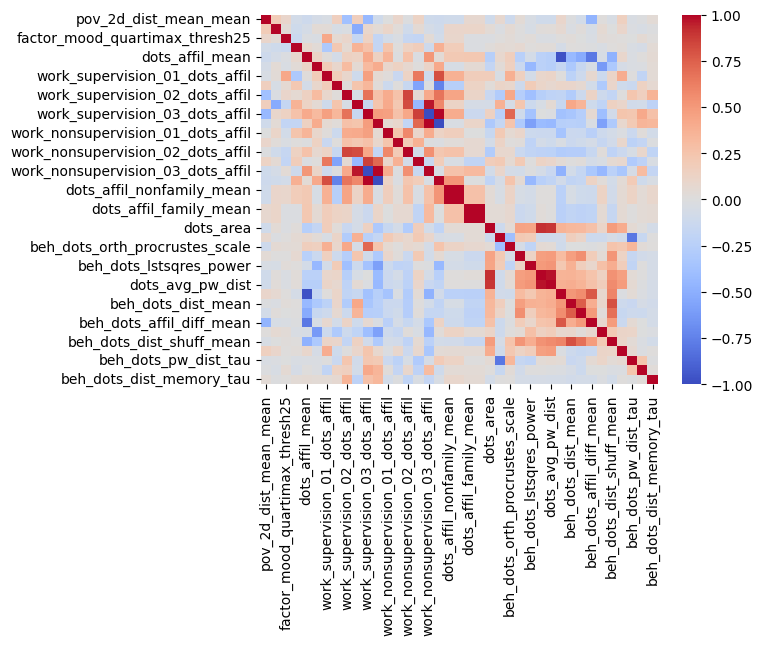

In [2]:
cols = [c for c in data.columns if ('dots' in c) & 
                        ('relationship' not in c) & 
                        ('quadrant' not in c) & 
                        ('adj' not in c) & 
                        ('extra' not in c)]
dots_cols = [c for c in cols if not any([cr in c for cr in character_roles])]
C = data[['pov_2d_dist_mean_mean', social_factor, mood_factor, compulsive_factor]+dots_cols].corr()
sns.heatmap(C, vmin=-1, vmax=1, cmap='coolwarm')
plt.show()

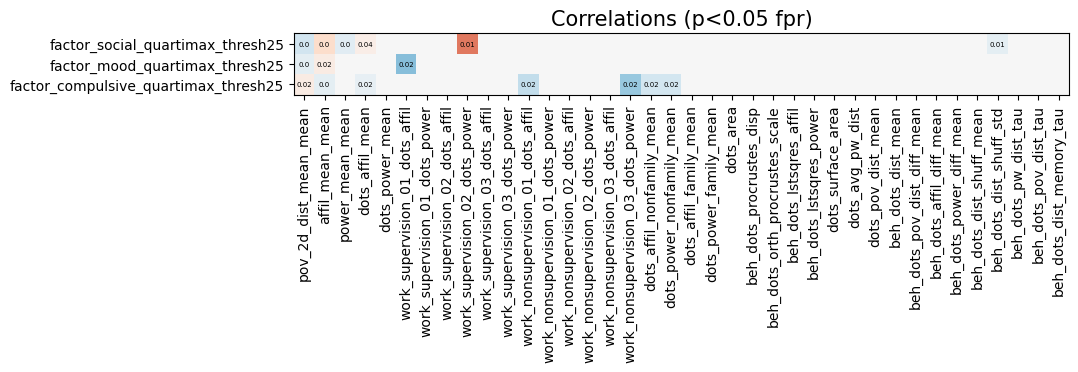

In [3]:
beh_df = data[['pov_2d_dist_mean_mean', 'affil_mean_mean', 'power_mean_mean'] + dots_cols]
sr_df  = data[[social_factor, mood_factor, compulsive_factor]]
plot_asymmetrical_corrmat(*calc_asymmetrical_corr_mat(beh_df, sr_df));

In [5]:
dots_xy = get_coords(data, which='dots')
beh_xy  = get_coords(data, which='task')

In [72]:
def pairwise_average_distance(coords1, coords2=None):
    """
    Computes the pairwise average distances between sets of coordinates. For each pair, it calculates
    the distances only for corresponding elements and averages these distances.

    Parameters:
    - coords1: A list or array of (x, y, ...) tuples representing the vertices of each shape in the first set.
    - coords2: Optional. A second list or array of (x, y, ...) tuples representing the vertices of each shape
               in the second set. If not provided, coords1 will be compared with itself.

    Returns:
    - A 2D numpy array where each element [i, j] represents the average distance between corresponding points
      of shape i from the first set and shape j from the second set (or within the first set if coords2 is None).
    """

    # Function to compute Euclidean distance between corresponding points of two shapes
    def average_distance(shape1, shape2):
        # Ensure numpy array for vectorized operations
        shape1 = np.array(shape1)
        shape2 = np.array(shape2)
        # Calculate distances between corresponding points
        distances = np.sqrt(np.sum((shape1 - shape2) ** 2, axis=1))
        # Return the average distance
        return np.mean(distances)

    # Convert the input lists to numpy arrays for ease of handling
    coords1 = np.array(coords1)
    if coords2 is None:
        coords2 = coords1

    n1, n2 = len(coords1), len(coords2)
    distance_matrix = np.zeros((n1, n2))

    # Compute pairwise average distances
    for i in range(n1):
        for j in range(n2):
            distance_matrix[i, j] = average_distance(coords1[i], coords2[j])

    return distance_matrix

def compute_polygon_overlap(points1, points2):
    """
    Compute the area of overlap between two polygons defined by their vertices.
    
    This function handles both convex and non-convex polygons by directly using the
    polygonal definitions without approximating them as convex hulls. It leverages
    the Shapely library to calculate the precise area of overlap.

    Parameters:
    - points1: A list or array of (x, y) tuples representing the vertices of the first polygon.
    - points2: A list or array of (x, y) tuples representing the vertices of the second polygon.

    Returns:
    - The area of the overlapping region between the two polygons. If there is no overlap,
      the function returns 0.

    Note:
    The order of the vertices in each input list/array should define a non-self-intersecting
    polygon. If the polygon is self-intersecting, the behavior is undefined.
    """
    # Create Polygon objects from the given points
    polygon1 = Polygon(points1)
    polygon2 = Polygon(points2)

    # Check if the polygons are valid (non-self-intersecting)
    if not polygon1.is_valid:
        raise ValueError("The first set of points does not form a valid polygon.")
    if not polygon2.is_valid:
        raise ValueError("The second set of points does not form a valid polygon.")

    # Compute the intersection (overlap) of the two polygons
    overlap_polygon = polygon1.intersection(polygon2)

    # Return the area of the overlap
    return overlap_polygon.area

def pairwise_polygon_overlap(coords1, coords2=None):
    """
    Computes the pairwise overlap area between two sets of polygons, or within a single set if only one is provided.
    Attempts to fix self-intersecting polygons using a buffer operation.
    """
    # Helper function to create a polygon and attempt to fix self-intersections
    def create_and_fix_polygon(coords):
        polygon = Polygon(coords)
        if not polygon.is_valid:
            polygon = polygon.buffer(0)
        return polygon

    # Initialize the list of Shapely Polygon objects for the first set, attempting to fix any self-intersections
    polygons1 = [create_and_fix_polygon(p) for p in coords1]

    if coords2 is not None:
        polygons2 = [create_and_fix_polygon(p) for p in coords2]
        n1, n2 = len(polygons1), len(polygons2)
        overlap_matrix = np.zeros((n1, n2))
        for i in range(n1):
            for j in range(n2):
                overlap_matrix[i, j] = polygons1[i].intersection(polygons2[j]).area
    else:
        n = len(polygons1)
        overlap_matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(i + 1, n):
                overlap = polygons1[i].intersection(polygons1[j]).area
                overlap_matrix[i, j] = overlap_matrix[j, i] = overlap

    return overlap_matrix

def pairwise_convexshape_overlap(coords1, coords2=None):
    """
    Compute the pairwise hypervolume overlap for one or two sets of shapes.
    
    Args:
    coords1 (np.array): Coordinates representing shapes for the first set (n_obs1, n_points, n_dimensions).
    coords2 (np.array, optional): Coordinates representing shapes for the second set (n_obs2, n_points, n_dimensions).
    
    Returns:
    np.array: Hypervolume overlap matrix. If one set is provided, returns (n_obs1, n_obs1).
              If two sets are provided, returns (n_obs1, n_obs2).
    """
    if coords2 is None:
        # If only one set of coords is provided, use the original logic
        coords = coords1
    else:
        # If two sets of coords are provided, concatenate them for processing
        coords = np.concatenate([coords1, coords2], axis=0)
        
    n_obs = coords.shape[0]
    overlap_matrix = np.ones((n_obs, n_obs))
    
    for i in range(n_obs):
        hull_i = ConvexHull(coords[i])
        vertices_i = hull_i.vertices
        polygon_i = Polygon(coords[i][vertices_i])
        area_i = hull_i.volume
        
        for j in range(i + 1, n_obs):
            hull_j = ConvexHull(coords[j])
            vertices_j = hull_j.vertices
            polygon_j = Polygon(coords[j][vertices_j])
            area_j = hull_j.volume
            
            overlap_area = polygon_i.intersection(polygon_j).area
            # Normalize overlap by the smaller of the two areas to keep the ratio within [0, 1]
            norm_factor = min(area_i, area_j)
            overlap_matrix[i, j] = overlap_matrix[j, i] = overlap_area / norm_factor if norm_factor > 0 else 0
    
    overlap_matrix = np.round(overlap_matrix, 2)
    
    # If two arrays were provided, adjust the overlap matrix to only include cross-overlaps
    if coords2 is not None:
        n_obs1 = coords1.shape[0]
        n_obs2 = coords2.shape[0]
        overlap_matrix = overlap_matrix[:n_obs1, n_obs1:n_obs1+n_obs2]
    
    assert np.all(overlap_matrix <= 1), 'Overlap matrix has values > 1'
    
    return overlap_matrix

def pairwise_shape_similarity(coords1, coords2=None, checkRotation=False, rotations=None):
    '''
    Computes the pairwise shape similarity between sets of coordinates or between two sets of coordinates.
    
    Arguments
    ---------
    coords1 : array
        3D array of shape (n, x_coords, y_coords) representing the first set of shapes.
    coords2 : array, optional
        3D array of shape (m, x_coords, y_coords) representing the second set of shapes. Default: None.
    checkRotation : bool, optional
        Whether to check for rotational similarity. Default: False.
    rotations : _type_, optional
        Specific rotations to check for if checkRotation is True. Default: None.

    Returns
    -------
    matrix 
        Symmetrical matrix of similarity between shapes within a set or cross-set similarity matrix if two sets are provided.

    [Adapted from original function by Matthew Schafer, github: @matty-gee; 2020ish]
    '''

    # Use coords1 if coords2 is not provided, otherwise concatenate coords1 and coords2 for processing
    coords = coords1 if coords2 is None else np.concatenate([coords1, coords2], axis=0)
    n = coords.shape[0]
    similarity_matrix = np.ones((n, n))
    
    for i in range(n):
        coords_i = coords[i, :, :]
        for j in range(i, n):
            if i != j:
                coords_j = coords[j,:,:]
                similarity_score = shape_similarity(coords_i, coords_j, checkRotation=checkRotation, rotations=rotations)
                similarity_matrix[i, j] = similarity_matrix[j, i] = similarity_score
                
    # If two sets of coordinates are provided, adjust the matrix to only include cross-set similarities
    if coords2 is not None:
        n1 = coords1.shape[0]
        n2 = coords2.shape[0]
        similarity_matrix = similarity_matrix[:n1, n1:n1+n2]

    return similarity_matrix

In [73]:
shape_sim = pairwise_average_distance(dots_xy, beh_xy)
shape_sim_self = shape_sim.diagonal()
shape_sim_others = symm_mat_to_ut_vec(shape_sim)
print(f'Beh-dots distance (self): {np.mean(shape_sim_self):.2f}')
print(f'Beh-dots distance (others): {np.mean(shape_sim_others):.2f}')

Beh-dots distance (self): 0.81
Beh-dots distance (others): 0.85


In [69]:
r, p = pearsonr(shape_sim_self, data[social_factor])
print(f'Pearson r: {r:.2f}, p: {p:.2f}')

Pearson r: -0.03, p: 0.42


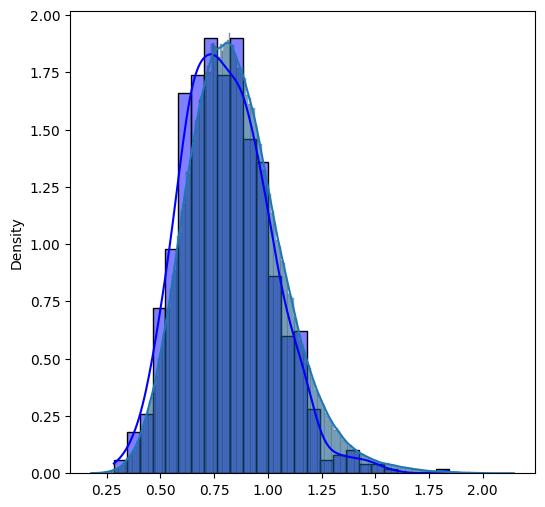

In [74]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
sns.histplot(shape_sim_self, color='blue', ax=ax, stat='density', kde=True)
sns.histplot(shape_sim_others, ax=ax, stat='density', kde=True);

# Self-perceived low-likability & low-impact <--> high social avoidance
- also, behavioral relationships

In [75]:
run_ols(X=['self_likability', 'self_impact'], y=social_factor, data=sample_dict['Validation']['data'], covariates=all_controls)[0]

,X,y,x,dof,adj_rsq,bic,aic,beta,se,95%_lb,95%_ub,t,p,p_left,p_right
0,Intercept + self_likability + self_impact + de...,factor_social_quartimax_thresh25,Intercept,241.0,0.217,520.91,492.77,0.876,0.092,0.695,1.057,9.536,1.706e-18,1.000e+00,8.530e-19
1,Intercept + self_likability + self_impact + de...,factor_social_quartimax_thresh25,self_likability,241.0,0.217,520.91,492.77,-0.240,0.045,-0.328,-0.151,-5.335,2.205e-07,1.102e-07,1.000e+00
2,Intercept + self_likability + self_impact + de...,factor_social_quartimax_thresh25,self_impact,241.0,0.217,520.91,492.77,-0.158,0.046,-0.249,-0.068,-3.453,6.553e-04,3.276e-04,9.997e-01
3,Intercept + self_likability + self_impact + de...,factor_social_quartimax_thresh25,demo_age,241.0,0.217,520.91,492.77,-0.088,0.042,-0.170,-0.007,-2.130,3.415e-02,1.707e-02,9.829e-01
4,Intercept + self_likability + self_impact + de...,factor_social_quartimax_thresh25,demo_gender_1W,241.0,0.217,520.91,492.77,-0.010,0.042,-0.092,0.073,-0.227,8.203e-01,4.102e-01,5.898e-01
5,Intercept + self_likability + self_impact + de...,factor_social_quartimax_thresh25,demo_race_white,241.0,0.217,520.91,492.77,-0.008,0.102,-0.209,0.193,-0.078,9.376e-01,4.688e-01,5.312e-01
6,Intercept + self_likability + self_impact + de...,factor_social_quartimax_thresh25,iq_score,241.0,0.217,520.91,492.77,-0.020,0.042,-0.103,0.063,-0.481,6.309e-01,3.154e-01,6.846e-01
7,Intercept + self_likability + self_impact + de...,factor_social_quartimax_thresh25,disorder,241.0,0.217,520.91,492.77,0.065,0.169,-0.268,0.399,0.387,6.991e-01,6.504e-01,3.496e-01


In [77]:
run_ols(X=['likability_mean', 'impact_mean'], y='pov_2d_dist_mean_mean', data=sample_dict['Validation']['data'], covariates=all_controls)[0]

,X,y,x,dof,adj_rsq,bic,aic,beta,se,95%_lb,95%_ub,t,p,p_left,p_right
0,Intercept + likability_mean + impact_mean + de...,pov_2d_dist_mean_mean,Intercept,225.0,0.167,683.21,598.79,4.908,0.301,4.315,5.501,16.309,5.420e-40,1.000e+00,2.710e-40
1,Intercept + likability_mean + impact_mean + de...,pov_2d_dist_mean_mean,likability_mean,225.0,0.167,683.21,598.79,-0.316,0.057,-0.427,-0.204,-5.571,7.211e-08,3.606e-08,1.000e+00
2,Intercept + likability_mean + impact_mean + de...,pov_2d_dist_mean_mean,impact_mean,225.0,0.167,683.21,598.79,-0.030,0.058,-0.145,0.084,-0.524,6.008e-01,3.004e-01,6.996e-01
3,Intercept + likability_mean + impact_mean + de...,pov_2d_dist_mean_mean,demo_age,225.0,0.167,683.21,598.79,0.039,0.095,-0.148,0.226,0.411,6.815e-01,6.592e-01,3.408e-01
4,Intercept + likability_mean + impact_mean + de...,pov_2d_dist_mean_mean,demo_gender_1W,225.0,0.167,683.21,598.79,0.026,0.052,-0.077,0.128,0.493,6.228e-01,6.886e-01,3.114e-01
5,Intercept + likability_mean + impact_mean + de...,pov_2d_dist_mean_mean,demo_race_white,225.0,0.167,683.21,598.79,0.080,0.127,-0.170,0.329,0.631,5.290e-01,7.355e-01,2.645e-01
6,Intercept + likability_mean + impact_mean + de...,pov_2d_dist_mean_mean,iq_score,225.0,0.167,683.21,598.79,0.020,0.055,-0.089,0.129,0.355,7.226e-01,6.387e-01,3.613e-01
7,Intercept + likability_mean + impact_mean + de...,pov_2d_dist_mean_mean,disorder,225.0,0.167,683.21,598.79,0.172,0.203,-0.228,0.572,0.847,3.977e-01,8.011e-01,1.989e-01
8,Intercept + likability_mean + impact_mean + de...,pov_2d_dist_mean_mean,ofb,225.0,0.167,683.21,598.79,0.189,0.336,-0.473,0.851,0.562,5.745e-01,7.127e-01,2.873e-01
9,Intercept + likability_mean + impact_mean + de...,pov_2d_dist_mean_mean,ofc,225.0,0.167,683.21,598.79,0.210,0.341,-0.462,0.882,0.615,5.389e-01,7.306e-01,2.694e-01


# Social avoidance relates to game distances but less so for dots distances...

### ... why?
- relates to snt distance: 'avoidance' can be thought of as a type of bias in navigation
- but doesnt relate to dots distance: they dont perceive the bias?
- navigation v. internal path integration?

behavior > subjective reports in evaluating relationships?

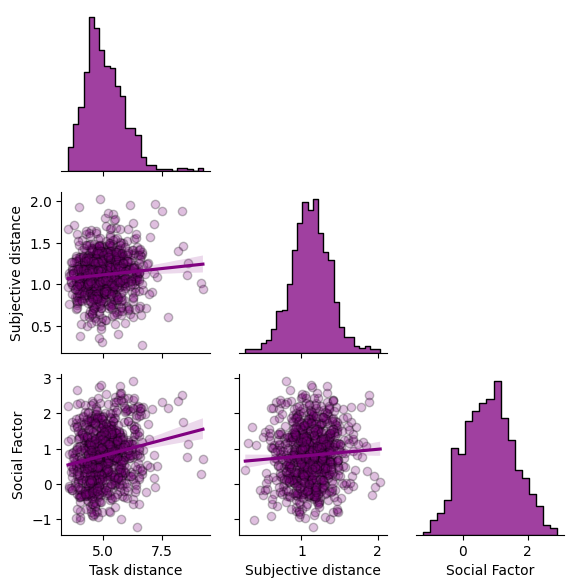

In [78]:
distance_vars = ['pov_2d_dist_mean_mean', 'dots_pov_dist_mean', social_factor]
distances     = data[distance_vars]

g = sns.PairGrid(distances, corner=True, diag_sharey=False, height=2)
g.map_lower(sns.regplot, scatter_kws={'alpha':0.25, 'edgecolor':'black'}, color='purple')
g.map_diag(sns.histplot, multiple="stack", element="step", color='purple')

# rename the axes
renames = ['Task distance', 'Subjective distance', 'Social Factor']
for i in range(3):
    g.axes[2, i].set_xlabel(renames[i])
    g.axes[i, 0].set_ylabel(renames[i])
plt.show()

## Last trial coordinates: how well do they map onto the dots coordinates?
If very well, then they should have small transformation weights: ie, they shouldnt need much change in basis to work
- no intercept: goes through origin 
- weight = 1: dots = task
- weight > 1: dots > task
- weight < 1: task < dots

In [79]:
weights = pd.DataFrame(columns=[f'{dim}_weight' for dim in ['dist','affil','power']] + [f'{dim}_bias' for dim in ['dist','affil','power']]) 

# theoretical max...
max_dots_dist = np.linalg.norm([-1, 1])
max_snt_dist  = np.linalg.norm([-12, 6])

for s in range(len(data)):

    #---------------------------
    # pov differences 
    #---------------------------

    X = data.iloc[s, :]['pov_2d_dist_mean_mean'].astype(float)
    y = data.iloc[s, :]['dots_pov_dist_mean'].astype(float)
    
    # scale by max
    data.loc[s, 'dist_diff']  = (X / max_snt_dist) - (y / max_dots_dist) # game - dots: so larger values means game locations are farther
    data.loc[s, 'dist_ratio'] = (X / max_snt_dist) / (y / max_dots_dist)

    # ols = LinearRegression(fit_intercept=False).fit(X, y)
    # data.loc[s, 'dist_weight'] = ols.coef_[0][0]

#     #---------------------------
#     # loop over dimensions
#     #---------------------------
#     for dim in ['affil', 'power']:

#         # X = characters x trials task coordinates (normalized)
#         # -- added 1 to both, so min-max=[0,2] & all betas > 0
#         # -- use coordinates or decisions?
#         # -- all trials or just the end?

#         dim_df = beh_df[beh_df['dimension'] == dim] 

#         # 
#         X = data.loc[s, [f'{dim}_coord_{role}' for role in character_roles[0:5]]].values.astype(float)
        
#         # y = characters dots coordinates (normalized) (5 x 1) 
#         y = data.loc[s, [f'{c}_dots_{dim}' for c in character_roles[0:5]]].values.astype(float)
        
#         # estimate weights
#         ols = LinearRegression(fit_intercept=False).fit(X[np.newaxis], y[np.newaxis])
# #         data.loc[s, [f'{dim}_weight']] = ols.coef_[0]
#         data.loc[s, [f'{dim}_bias']] = ols.intercept_
        
#         data.loc[s, [f'{dim}_diff']] = np.mean(X - y)
    
# sns.histplot(data['dist_diff'], bins=30, color='purple')
# plt.show()

# sns.histplot(data['affil_diff'], bins=30, color='blue')
# sns.histplot(data['power_diff'], bins=30, color='red')
# plt.xlabel('SNT locations - dots locations')
# plt.show()

## Behavior distances are bigger than dots distances in avoidance
#### + : task location > dots location
#### - : task location < dots location
either could be a diff. between internal and what they want to project OR some social mis-judgment

In [83]:
# ys = [c for c in data.columns if ('beh_dots' in c) & (('mean' in c) or ('tau' in c)) & ('adj' not in c)]
ys = ['beh_dots_affil_diff_mean', 'beh_dots_power_diff_mean']
x_ = social_factor
for y_ in ys:
    for s, sample in enumerate(samples[:2]):

        df    = sample_dict[sample]['data']
        color = sample_dict[sample]['color']
        mask = np.isfinite(df[y_]) & np.isfinite(df[x_])
        xz = scipy.stats.zscore(df[x_][mask])
        yz = scipy.stats.zscore(df[y_][mask])

        # correlation
        results, ols_obj = run_ols(X=[y_], y=x_, data=df, covariates=demo_controls[:3])
        pvalue = ols_obj.pvalues[y_] # 2-sided
        print(f'n={np.sum(mask)}, {y_}: p={np.round(pvalue, 4)}')

n=579, beh_dots_affil_diff_mean: p=0.4106
n=255, beh_dots_affil_diff_mean: p=0.0589
n=579, beh_dots_power_diff_mean: p=0.1248
n=255, beh_dots_power_diff_mean: p=0.6451


In [81]:
display(run_ols(X=['beh_dots_affil_diff_mean', 'beh_dots_power_diff_mean', 'beh_dots_pov_dist_diff_mean'], y=social_factor, data=data, covariates=demo_controls + ['sample'])[1].summary())
display(run_ols(X=['beh_dots_pov_dist_diff_mean'], y=social_factor, data=data, covariates=demo_controls + ['sample'])[1].summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     factor_social_quartimax_thresh25   R-squared:                       0.029
Model:                                          OLS   Adj. R-squared:                  0.018
Method:                               Least Squares   F-statistic:                     2.690
Date:                              Fri, 09 Feb 2024   Prob (F-statistic):            0.00437
Time:                                      21:46:54   Log-Likelihood:                -950.40
No. Observations:                               827   AIC:                             1921.
Df Residuals:                                   817   BIC:                             1968.
Df Model:                                         9                                         
Covariance Type:                          nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.7544      0.058     12.903      0.000       0.640       0.869
beh_dots_affil_diff_mean       -0.0832      0.032     -2.626      0.009      -0.145      -0.021
beh_dots_power_diff_mean        0.0451      0.027      1.674      0.095      -0.008       0.098
beh_dots_pov_dist_diff_mean     0.0522      0.031      1.670      0.095      -0.009       0.114
demo_age                       -0.0842      0.028     -2.984      0.003      -0.140      -0.029
demo_gender_1W                 -0.0141      0.027     -0.518      0.604      -0.068       0.039
demo_race_white                 0.0430      0.066      0.656      0.512      -0.086       0.172
iq_score                        0.0331      0.028      1.195      0.233      -0.021       0.087
disorder                        0.2727      0.144      1.889      0.059      -0.011       0.556
sample                          0.0467      0.061      0.769      0.442      -0.072       0.166
==============================================================================
Omnibus:                       10.195   Durbin-Watson:                   2.106
Prob(Omnibus):                  0.006   Jarque-Bera (JB):                7.398
Skew:                           0.112   Prob(JB):                       0.0247
Kurtosis:                       2.594   Cond. No.                         7.19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     factor_social_quartimax_thresh25   R-squared:                       0.018
Model:                                          OLS   Adj. R-squared:                  0.010
Method:                               Least Squares   F-statistic:                     2.134
Date:                              Fri, 09 Feb 2024   Prob (F-statistic):             0.0380
Time:                                      21:46:54   Log-Likelihood:                -955.00
No. Observations:                               827   AIC:                             1926.
Df Residuals:                                   819   BIC:                             1964.
Df Model:                                         7                                         
Covariance Type:                          nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.7643      0.059     13.049      0.000       0.649       0.879
beh_dots_pov_dist_diff_mean     0.0110      0.027      0.408      0.683      -0.042       0.064
demo_age                       -0.0812      0.028     -2.870      0.004      -0.137      -0.026
demo_gender_1W                 -0.0108      0.027     -0.395      0.693      -0.064       0.043
demo_race_white                 0.0303      0.066      0.462      0.644      -0.099       0.159
iq_score                        0.0221      0.027      0.804      0.422      -0.032       0.076
disorder                        0.2542      0.145      1.757      0.079      -0.030       0.538
sample                          0.0481      0.061      0.794      0.427      -0.071       0.167
==============================================================================
Omnibus:                       10.976   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.004   Jarque-Bera (JB):                7.850
Skew:                           0.116   Prob(JB):                       0.0197
Kurtosis:                       2.582   Cond. No.                         7.17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Find variables that predict this difference
- social factor: more, more distance (+) [other factors are close to sig. when incl.]
- gender: women, less distance 
- memory: less, more distance (-)


In [ ]:
# can i correlate a behavioral variable w the diff?
data['demo_gender_1W_v0'] = (data['demo_gender_1W'] == 1).astype(int)
demo_controls = ['demo_age', 'C(demo_gender_1W_v0)', 'C(demo_race_white)', 'iq_score']
run_ols(['consistency_mean', 'factor_social_min', 'factor_mood_min', 'factor_compulsive_min', 'memory_mean'], 
         'taskVdots_pov_dist_mean', data, covariates=demo_controls)[1].summary()